In [ ]:
!py -m pip install pyvista --upgrade
!py -m pip install ipympl --upgrade
!py -m pip install trame --upgrade
!py -m pip install scipy --upgrade
!py -m pip install imageio --upgrade

In [178]:
import pyvista as pv
import numpy as np

import matplotlib.pyplot as plt
import imageio

from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy import optimize
from scipy.special import comb

from math import sqrt, cos, sin, pi, atan2, degrees

from shapely import affinity, distance
from shapely.geometry import Polygon, Point, LinearRing, LineString, MultiPoint
from shapely.plotting import plot_polygon, plot_points, plot_line
from shapely.ops import transform
from shapely.affinity import rotate

from tqdm.notebook import tqdm

In [ ]:
def matan(point):
    angle = atan2(point.y, point.x)
    if angle <= 0: angle += 2*pi
    return angle

def norma(point):
    return Point(0,0).distance(point)

def distance(pt1, pt2):
    return sqrt((pt2.x-pt1.x)**2+(pt2.y-pt1.y)**2)

In [128]:
def GetAverageCurvature(pts):
    al = []
    for i in range(len(pts)):
        al.append([pts[i].x, pts[i].y])

    a = np.array(al)
    dx_dt = np.gradient(a[:, 0])
    dy_dt = np.gradient(a[:, 1])
    velocity = np.array([ [dx_dt[i], dy_dt[i]] for i in range(dx_dt.size)])

    ds_dt = np.sqrt(dx_dt * dx_dt + dy_dt * dy_dt)

    tangent = np.array([1/ds_dt]).transpose() * velocity

    tangent_x = tangent[:, 0]
    tangent_y = tangent[:, 1]

    deriv_tangent_x = np.gradient(tangent_x)
    deriv_tangent_y = np.gradient(tangent_y)

    dT_dt = np.array([ [deriv_tangent_x[i], deriv_tangent_y[i]] for i in range(deriv_tangent_x.size)])

    length_dT_dt = np.sqrt(deriv_tangent_x * deriv_tangent_x + deriv_tangent_y * deriv_tangent_y)

    normal = np.array([1/length_dT_dt]).transpose() * dT_dt

    d2s_dt2 = np.gradient(ds_dt)
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)

    curvature = np.abs(d2x_dt2 * dy_dt - dx_dt * d2y_dt2) / (dx_dt * dx_dt + dy_dt * dy_dt)**1.5
    return np.mean(curvature)

def GetCornerIndices(pts, threshold):
    al = []
    for i in range(len(pts)):
        al.append([pts[i].x, pts[i].y])

    a = np.array(al)
    dx_dt = np.gradient(a[:, 0])
    dy_dt = np.gradient(a[:, 1])
    velocity = np.array([ [dx_dt[i], dy_dt[i]] for i in range(dx_dt.size)])

    ds_dt = np.sqrt(dx_dt * dx_dt + dy_dt * dy_dt)

    tangent = np.array([1/ds_dt]).transpose() * velocity

    tangent_x = tangent[:, 0]
    tangent_y = tangent[:, 1]

    deriv_tangent_x = np.gradient(tangent_x)
    deriv_tangent_y = np.gradient(tangent_y)

    dT_dt = np.array([ [deriv_tangent_x[i], deriv_tangent_y[i]] for i in range(deriv_tangent_x.size)])

    length_dT_dt = np.sqrt(deriv_tangent_x * deriv_tangent_x + deriv_tangent_y * deriv_tangent_y)

    normal = np.array([1/length_dT_dt]).transpose() * dT_dt

    d2s_dt2 = np.gradient(ds_dt)
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)

    curvature = np.abs(d2x_dt2 * dy_dt - dx_dt * d2y_dt2) / (dx_dt * dx_dt + dy_dt * dy_dt)**1.5
    t_component = np.array([d2s_dt2] * 2).transpose()
    n_component = np.array([curvature * ds_dt * ds_dt] * 2).transpose()

    acceleration = t_component * tangent + n_component * normal

    # plt.plot(curvature)
    return [idx for idx, val in enumerate(curvature) if val>=threshold]

def GetNormalVectors(pts):
    al = []
    for i in range(len(pts)):
        al.append([pts[i].x, pts[i].y])

    a = np.array(al)
    dx_dt = np.gradient(a[:, 0])
    dy_dt = np.gradient(a[:, 1])
    velocity = np.array([ [dx_dt[i], dy_dt[i]] for i in range(dx_dt.size)])

    ds_dt = np.sqrt(dx_dt * dx_dt + dy_dt * dy_dt)

    tangent = np.array([1/ds_dt]).transpose() * velocity

    tangent_x = tangent[:, 0]
    tangent_y = tangent[:, 1]

    deriv_tangent_x = np.gradient(tangent_x)
    deriv_tangent_y = np.gradient(tangent_y)

    dT_dt = np.array([ [deriv_tangent_x[i], deriv_tangent_y[i]] for i in range(deriv_tangent_x.size)])

    length_dT_dt = np.sqrt(deriv_tangent_x * deriv_tangent_x + deriv_tangent_y * deriv_tangent_y)

    norms = np.array([1/length_dT_dt]).transpose() * dT_dt

    normals = []
    for v in norms:
        normals.append(Point(v[0], v[1]))
    return normals

In [129]:
def crcl(pt1, pt2, pt3):
   z1 = complex(pt1.x, pt1.y)
   z2 = complex(pt2.x, pt2.y)
   z3 = complex(pt3.x, pt3.y)

   if z1 == z2:
      print("colinear")
      return None

   def f(z):
      return (z-z1)/(z2-z1)

   def f_inv(w):
      return z1+(z2-z1)*w

   w3 = f(z3)
   if w3.imag == 0: #may be abs(w3.imag) < eps
      print("colinear")
      return None
   
   d = (w3-w3*w3.conjugate())/(w3-w3.conjugate())
   c = f_inv(d)
   pt = Point(c.real, c.imag)
   r = abs(z1-c)
   return pt, r

In [130]:
# def GetBrutingTrace(rough_pts, target_pts, step, steps):
#     alpha = step / steps
#     bruting_rough_trace_pts = []
#     i_max , dst_max = 0, rough_pts[0].distance(target_pts[0])
#     for i in range(1, len(rough_pts)):
#         dst = rough_pts[i].distance(target_pts[i])
#         if dst > dst_max: 
#             i_max, dst_max = i, dst
#     x1, y1 = rough_pts[i_max].x, rough_pts[i_max].y
#     x2, y2 = target_pts[i_max].x, target_pts[i_max].y
#     ptc, rad = crcl(rough_pts[0], rough_pts[-1], Point((1-alpha)*x1+alpha*x2, (1-alpha)*y1+alpha*y2))
#     angle1 = atan2(rough_pts[0].y-ptc.y, rough_pts[0].x-ptc.x)
#     angle2 = atan2(rough_pts[-1].y-ptc.y, rough_pts[-1].x-ptc.x)
#     if angle1 >= angle2:
#         val = angle1
#         angle1 = angle2
#         angle2 = val
    
#     if step%2 == 0:
#         val = angle1
#         angle1 = angle2
#         angle2 = val
        
#     for i in range(10000):
#         gamma = i / 10000
#         angle = (1-gamma)*angle1+gamma*angle2
#         bruting_rough_trace_pts.append(Point(ptc.x+rad*cos(angle), ptc.y+rad*sin(angle)))

#     bruting_rough_trace = LineString(bruting_rough_trace_pts)
#     delta_length = bruting_rough_trace.length / (len(rough_pts) - 1)

#     bruting_trace_pts = []
#     for i in range(len(rough_pts)):
#         bruting_trace_pts.append(bruting_rough_trace.interpolate(i*delta_length))

#     # bruting_trace = LineString(bruting_trace_pts)

#     # indices = GetCornerIndices(bruting_trace_pts, 100)
#     # if len(indices) > 0:
#     #     vnum = 40
#     #     delta_length = bruting_rough_trace.length / (len(rough_pts) - 1 - len(indices)*vnum)

#     #     bruting_trace_mod_pts = []
#     #     for i in range(len(rough_pts)-len(indices)*vnum):
#     #         if i not in indices:
#     #             bruting_trace_mod_pts.append(bruting_trace.interpolate(i*delta_length))
#     #         else:
#     #             for j in range(vnum):
#     #                 bruting_trace_mod_pts.append(bruting_trace_pts[i])
#     #     bruting_trace_pts = bruting_trace_mod_pts

#     # k = 0
#     # plot_points(rough_pts, color=(0,0,1), markersize=0.5, label="rough diamond")
#     # plot_points(bruting_rough_trace_pts, color=(0,1,0), markersize=0.5, label="bruting trace")
#     # plot_points(target_pts, color=(1,0,0), markersize=0.5, label="target diamond")
    
#     # plot_points(bruting_rough_trace_pts[k], color=(0,0,0), markersize=5, label="bruting trace")
#     # plt.xlim(2.5, 2.8)
#     # plt.ylim(1.4, 1.7)

#     # # angles = []
#     # # for i in range(len(bruting_trace_pts)):
#     # #     angles.append(matan(bruting_trace_pts[i]))
#     # # plt.plot(angles)

#     # print(len(rough_pts), len(bruting_trace_pts))
    
#     return bruting_trace_pts

In [191]:
def GetContourFromOBJ(filename):
    return LinearRing(MultiPoint(np.delete(pv.read(filename).project_points_to_plane().points, 2, 1)).convex_hull.boundary.coords)

def Contour2Points(contour, n):
    contour_pts = []
    for i in range(n):
        contour_pts.append(contour.intersection(LineString([(0,0), (20*cos((i/n)*2*pi), 20*sin((i/n)*2*pi))])))
    return contour_pts

def PointsBetweenAngles(contour_pts, angle_min, angle_max):
    for i in range(1, len(contour_pts)):
        if matan(contour_pts[i]) >= angle_min:
            i_min = i
            break
    for i in reversed(range(len(contour_pts))):
        if matan(contour_pts[i]) <= angle_max:
            i_max = i
            break
    return contour_pts[i_min:i_max]

def GetAngleOfRotation(contour_pts, pts, i1, i2):
    angle1, angle2 = matan(Point(pts.geoms[i1].x, pts.geoms[i1].y)), matan(Point(pts.geoms[i2].x, pts.geoms[i2].y))
    i_max, nrm_max = 0, norma(contour_pts[0])
    for i in range(1, len(contour_pts)):
        angle_cur = matan(contour_pts[i])
        if angle1 <= angle_cur and angle_cur <= angle2:
            nrm = norma(contour_pts[i])
            if nrm > nrm_max:
                nrm_max = nrm
                i_max = i
    return matan(contour_pts[i_max])

def RotateListOfPoints(contour_pts, angle):
    rotated_contour_pts = []
    for i in range(len(contour_pts)):
        rotated_contour_pts.append(rotate(contour_pts[i], angle, origin=Point(0.0,0.0), use_radians=True))
    return rotated_contour_pts

def TransformListOfPoints(contour_pts, x_trans, y_trans):
    transformed_contour_pts = []
    for i in range(len(contour_pts)):
        transformed_contour_pts.append(transform(lambda x, y, z=None: (x+(x_trans), y+(y_trans)), contour_pts[i]))
    return transformed_contour_pts

# def GetMinDistanceBetweenListsOfPoints(pts1, pts2):
#     dst_min = 1e+20
#     for i in range(len(pts1)):
#         pt = pts1[i]
#         for j in range(len(pts2)):
#             dst = pt.distance(pts2[j])
#             if dst <= dst_min:
#                 dst_min = dst
#     return dst_min

# def GetBrutingTrace(rough_pts, target_pts, step, steps):
#     alpha = step / steps
#     bruting_trace_pts = []
#     if step%2 != 0:
#         for i in range(len(rough_pts)):
#             x1, y1 = rough_pts[i].x, rough_pts[i].y
#             x2, y2 = target_pts[i].x, target_pts[i].y
#             bruting_trace_pts.append(Point((1-alpha)*x1+alpha*x2, (1-alpha)*y1+alpha*y2))
#     else:
#         for i in reversed(range(len(rough_pts))):
#             x1, y1 = rough_pts[i].x, rough_pts[i].y
#             x2, y2 = target_pts[i].x, target_pts[i].y
#             bruting_trace_pts.append(Point((1-alpha)*x1+alpha*x2, (1-alpha)*y1+alpha*y2))
    
#     return bruting_trace_pts

def GetPointOnLineWithDistance(line, distance):
    if distance < 0.0 or distance > line.length:
        return None
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return Point(coords[i][0], coords[i][1])
        if pd > distance:
           return line.interpolate(distance)

def GetBrutingTrace(rough_pts, target_pts, step, steps, threshold):
    alpha = step / steps
    bruting_rough_trace_pts = []
    if step%2 != 0:
        for i in range(len(rough_pts)):
            x1, y1 = rough_pts[i].x, rough_pts[i].y
            x2, y2 = target_pts[i].x, target_pts[i].y
            bruting_rough_trace_pts.append(Point((1-alpha)*x1+alpha*x2, (1-alpha)*y1+alpha*y2))
    else:
        for i in reversed(range(len(rough_pts))):
            x1, y1 = rough_pts[i].x, rough_pts[i].y
            x2, y2 = target_pts[i].x, target_pts[i].y
            bruting_rough_trace_pts.append(Point((1-alpha)*x1+alpha*x2, (1-alpha)*y1+alpha*y2))
    
    bruting_trace_pts = bruting_rough_trace_pts
    
    # mean = GetAverageCurvature(bruting_rough_trace_pts)
    indices = GetCornerIndices(bruting_rough_trace_pts, threshold)

    while len(indices) != 0:
        # print(len(indices))
        bruting_trace_pts = []
        for i in range(len(bruting_rough_trace_pts)):
            if i not in indices:
                bruting_trace_pts.append(bruting_rough_trace_pts[i])
            else:
                pt1 = bruting_rough_trace_pts[i-1]
                pt2 = bruting_rough_trace_pts[i+1]
                pt = bruting_rough_trace_pts[i]
                nrm = norma(pt)
                coeff = (norma(pt1)+norma(pt2))/2
                bruting_trace_pts.append(Point(coeff*pt.x/nrm, coeff*pt.y/nrm))

        bruting_rough_trace_pts = bruting_trace_pts
        # mean = GetAverageCurvature(bruting_rough_trace_pts)
        indices = GetCornerIndices(bruting_rough_trace_pts, threshold)
    
    delta_len = LineString(bruting_trace_pts).length/(len(rough_pts)-1)
    # line = LineString(bruting_trace_pts).segmentize(max_segment_length=delta_len)
    line = LineString(bruting_trace_pts)

    bruting_trace_pts = []
    for i in tqdm(range(len(rough_pts))):
        bruting_trace_pts.append(GetPointOnLineWithDistance(line, i*delta_len))

    return bruting_trace_pts

In [192]:
def GetParallelOffset(bruting_trace_pts, j, R):
    normal_vectors = []
    for i in range(len(bruting_trace_pts)-1):
        pt1, pt2 = bruting_trace_pts[i], bruting_trace_pts[i+1]
        x1, y1 = pt1.x, pt1.y
        x2, y2 = pt2.x, pt2.y
        nrm = sqrt((x2-x1)**2+(y2-y1)**2)
        if j%2 != 0:
            normal_vectors.append(Point(R*(y2-y1)/nrm, -R*(x2-x1)/nrm))
        else:
            normal_vectors.append(Point(-R*(y2-y1)/nrm, R*(x2-x1)/nrm))
    
    normal_vertices = []
    normal_vertices.append(normal_vectors[0])
    for i in range(len(normal_vectors)-1):
        x = (normal_vectors[i].x+normal_vectors[i+1].x)/2
        y = (normal_vectors[i].y+normal_vectors[i+1].y)/2
        normal_vertices.append(Point(x, y))
    normal_vertices.append(normal_vectors[-1])

    disk_trace_pts = []
    for i in range(len(bruting_trace_pts)):
        x = bruting_trace_pts[i].x+normal_vertices[i].x
        y = bruting_trace_pts[i].y+normal_vertices[i].y
        disk_trace_pts.append(Point(x, y))

    # return list(MultiPoint(LineString(bruting_trace_pts).parallel_offset(R, 'right', join_style=1).coords).geoms)
    return disk_trace_pts

# def GetParallelOffset(bruting_trace_pts, j, R):
#     nrms = GetNormalVectors(bruting_trace_pts)
#     print(nrms)


def GetReversed(pts):
    reversed_pts = []
    for i in reversed(range(len(pts))):
        reversed_pts.append(pts[i])
    return reversed_pts

In [193]:
def CreateDisk(R):
    disk_pts = []
    for i in range(1000):
        angle = (i/1000)*2*pi
        disk_pts.append(Point(R*cos(angle), R*sin(angle)))
    return disk_pts

def GetTrace(rough_pts, target_pts, disk_trace_pts, disk, R, j, k):
    if j%2 == 0:
        rough_string = LinearRing(rough_pts)
        npts = rough_string.intersection(disk)
        opts = rough_string.intersection(LineString(target_pts))

        if opts.geom_type == "MultiPoint":
            reper_angle1 = matan(opts.geoms[0])
            reper_angle2 = matan(opts.geoms[1])
        else:
            pt1 = Point(opts.geoms[0].coords[1][0], opts.geoms[0].coords[1][1])
            pt2 =  Point(opts.geoms[1].coords[0][0], opts.geoms[1].coords[0][1])
            spatial_len = pt1.distance(pt2)
            for i in range(len(opts.geoms)-1):
                pt1 = Point(opts.geoms[i].coords[1][0], opts.geoms[i].coords[1][1])
                pt2 =  Point(opts.geoms[i+1].coords[0][0], opts.geoms[i+1].coords[0][1])
                if pt1.distance(pt2) > 10*spatial_len:
                    i_reper = i
                    break

            reper_angle1 = atan2(opts.geoms[i_reper].coords[0][1], opts.geoms[i_reper].coords[0][0])
            reper_angle2 = atan2(opts.geoms[i_reper+1].coords[1][1], opts.geoms[i_reper+1].coords[1][0])
            if reper_angle1 <= 0: reper_angle1 += 2*pi
            if reper_angle2 <= 0: reper_angle2 += 2*pi

        anglec = matan(disk_trace_pts[k])
        rc = norma(disk_trace_pts[k])

        trace = []
        if npts.geom_type == 'LineString':
            if len(npts.coords) != 0:
                angle_edge = atan2(npts.coords[-1][1], npts.coords[-1][0])
                if angle_edge <= 0:
                    angle_edge += 2*pi

                for i in range(len(rough_pts)):
                    if matan(rough_pts[i]) >= angle_edge:
                        i_intersect = i
                        break

                for i in (range(len(rough_pts))):
                    if i < k:
                        trace.append(target_pts[i])
                    elif k <= i and i < i_intersect:
                        angle_cur = matan(rough_pts[i])

                        # if angle_cur > angle_edge:
                        #     angle_cur -= 1e-3
                        
                        lr = rc*cos(angle_cur-anglec)-sqrt(R**2-(rc*sin(angle_cur-anglec))**2)
                        trace.append(Point(lr*cos(angle_cur), lr*sin(angle_cur)))
                    else:
                        trace.append(rough_pts[i])
            else:
                angle_c = matan(target_pts[k])

                if rough_string.distance(disk.centroid) > R:
                    if angle_c < reper_angle1:
                        for i in (range(len(rough_pts))):
                            trace.append(rough_pts[i])
                    if reper_angle2 <= angle_c:
                        for i in range(len(target_pts)):
                            if matan(target_pts[i]) >= reper_angle1:
                                i_intersect1 = i
                                break
                        for i in range(len(target_pts)):
                            if matan(target_pts[i]) >= reper_angle2:
                                i_intersect2 = i
                                break
                        for i in range(len(rough_pts)):
                            if i < i_intersect1:
                                trace.append(rough_pts[i])
                            elif i_intersect1 <= i and i < i_intersect2:
                                trace.append(target_pts[i])
                            else:
                                trace.append(rough_pts[i])
                else:
                    for i in (range(len(rough_pts))):
                        if i < k:
                            trace.append(target_pts[i])
                        else:
                            trace.append(rough_pts[i])
        else:
            if len(npts.geoms[0].coords) != 0:

                angle_edge = atan2(npts.geoms[0].coords[-1][1], npts.geoms[0].coords[-1][0])
                if angle_edge <= 0:
                    angle_edge += 2*pi

                for i in range(len(rough_pts)):
                    if matan(rough_pts[i]) >= angle_edge:
                        i_intersect = i
                        break

                for i in (range(len(rough_pts))):
                    if i < k:
                        trace.append(target_pts[i])
                    elif k <= i and i < i_intersect:
                        angle_cur = matan(rough_pts[i])

                        # if angle_cur > angle_edge:
                        #     angle_cur -= 1e-3
                            
                        lr = rc*cos(angle_cur-anglec)-sqrt(R**2-(rc*sin(angle_cur-anglec))**2)
                        trace.append(Point(lr*cos(angle_cur), lr*sin(angle_cur)))
                    else:
                        trace.append(rough_pts[i])
            else:
                angle_c = matan(target_pts[k])

                if rough_string.distance(disk.centroid) > R:
                    if angle_c < reper_angle1:
                        for i in (range(len(rough_pts))):
                            trace.append(rough_pts[i])
                    if reper_angle2 <= angle_c:
                        for i in range(len(target_pts)):
                            if matan(target_pts[i]) >= reper_angle1:
                                i_intersect1 = i
                                break
                        for i in range(len(target_pts)):
                            if matan(target_pts[i]) >= reper_angle2:
                                i_intersect2 = i
                                break
                        for i in range(len(rough_pts)):
                            if i < i_intersect1:
                                trace.append(rough_pts[i])
                            elif i_intersect1 <= i and i < i_intersect2:
                                trace.append(target_pts[i])
                            else:
                                trace.append(rough_pts[i])
                else:
                    for i in (range(len(rough_pts))):
                        if i < k:
                            trace.append(target_pts[i])
                        else:
                            trace.append(rough_pts[i])
    else:
        rough_string = LinearRing(rough_pts)
        npts = rough_string.intersection(disk)
        opts = rough_string.intersection(LineString(target_pts))

        if opts.geom_type == "MultiPoint":
            reper_angle1 = matan(opts.geoms[0])
            reper_angle2 = matan(opts.geoms[1])
        else:
            pt1 = Point(opts.geoms[0].coords[1][0], opts.geoms[0].coords[1][1])
            pt2 =  Point(opts.geoms[1].coords[0][0], opts.geoms[1].coords[0][1])
            spatial_len = pt1.distance(pt2)
            for i in range(len(opts.geoms)-1):
                pt1 = Point(opts.geoms[i].coords[1][0], opts.geoms[i].coords[1][1])
                pt2 =  Point(opts.geoms[i+1].coords[0][0], opts.geoms[i+1].coords[0][1])
                if pt1.distance(pt2) > 10*spatial_len:
                    i_reper = i
                    break

            reper_angle1 = atan2(opts.geoms[i_reper].coords[0][1], opts.geoms[i_reper].coords[0][0])
            reper_angle2 = atan2(opts.geoms[i_reper+1].coords[1][1], opts.geoms[i_reper+1].coords[1][0])
            if reper_angle1 <= 0: reper_angle1 += 2*pi
            if reper_angle2 <= 0: reper_angle2 += 2*pi

            if reper_angle1 < reper_angle2:
                val = reper_angle1
                reper_angle1 = reper_angle2
                reper_angle2 = val

        anglec = matan(disk_trace_pts[k])
        rc = norma(disk_trace_pts[k])

        trace = []
        if npts.geom_type == 'LineString':
            if len(npts.coords) != 0:
                angle_edge = atan2(npts.coords[-1][1], npts.coords[-1][0])
                if angle_edge <= 0:
                    angle_edge += 2*pi

                for i in range(len(rough_pts)):
                    if matan(rough_pts[i]) <= angle_edge:
                        i_intersect = i
                        break

                for i in (range(len(rough_pts))):
                    if i < k:
                        trace.append(target_pts[i])
                    elif k <= i and i < i_intersect:
                        angle_cur = matan(rough_pts[i])

                        # if angle_cur < angle_edge:
                        #     angle_cur += 1e-3
                        
                        lr = rc*cos(angle_cur-anglec)-sqrt(R**2-(rc*sin(angle_cur-anglec))**2)
                        trace.append(Point(lr*cos(angle_cur), lr*sin(angle_cur)))
                    else:
                        trace.append(rough_pts[i])
            else:
                angle_c = matan(target_pts[k])

                if rough_string.distance(disk.centroid) > R:
                    if angle_c > reper_angle2:
                        for i in (range(len(rough_pts))):
                            trace.append(rough_pts[i])
                    if angle_c <= reper_angle1:
                        for i in range(len(target_pts)):
                            if matan(target_pts[i]) <= reper_angle1:
                                i_intersect1 = i
                                break
                        for i in range(len(target_pts)):
                            if matan(target_pts[i]) <= reper_angle2:
                                i_intersect2 = i
                                break
                        for i in range(len(rough_pts)):
                            if i < i_intersect1:
                                trace.append(rough_pts[i])
                            elif i_intersect1 <= i and i < i_intersect2:
                                trace.append(target_pts[i])
                            else:
                                trace.append(rough_pts[i])
                else:
                    for i in (range(len(rough_pts))):
                        if i < k:
                            trace.append(target_pts[i])
                        else:
                            trace.append(rough_pts[i])
        else:
            if len(npts.geoms[0].coords) != 0:
                angle_edge = atan2(npts.geoms[0].coords[-1][1], npts.geoms[0].coords[-1][0])
                if angle_edge <= 0:
                    angle_edge += 2*pi

                for i in range(len(rough_pts)):
                    if matan(rough_pts[i]) <= angle_edge:
                        i_intersect = i
                        break

                for i in (range(len(rough_pts))):
                    if i < k:
                        trace.append(target_pts[i])
                    elif k <= i and i < i_intersect:
                        angle_cur = matan(rough_pts[i])

                        # if angle_cur < angle_edge:
                        #     angle_cur += 1e-3
                            
                        lr = rc*cos(angle_cur-anglec)-sqrt(R**2-(rc*sin(angle_cur-anglec))**2)
                        trace.append(Point(lr*cos(angle_cur), lr*sin(angle_cur)))
                    else:
                        trace.append(rough_pts[i])
            else:
                angle_c = matan(target_pts[k])

                if rough_string.distance(disk.centroid) > R:
                    if angle_c > reper_angle2:
                        for i in (range(len(rough_pts))):
                            trace.append(rough_pts[i])
                    if angle_c <= reper_angle1:
                        for i in range(len(target_pts)):
                            if matan(target_pts[i]) <= reper_angle1:
                                i_intersect1 = i
                                break
                        for i in range(len(target_pts)):
                            if matan(target_pts[i]) <= reper_angle2:
                                i_intersect2 = i
                                break
                        for i in range(len(rough_pts)):
                            if i < i_intersect1:
                                trace.append(rough_pts[i])
                            elif i_intersect1 <= i and i < i_intersect2:
                                trace.append(target_pts[i])
                            else:
                                trace.append(rough_pts[i])
                else:
                    for i in (range(len(rough_pts))):
                        if i < k:
                            trace.append(target_pts[i])
                        else:
                            trace.append(rough_pts[i])
        
    return trace

  0%|          | 0/1913 [00:00<?, ?it/s]

  0%|          | 0/1913 [00:00<?, ?it/s]

  0%|          | 0/1913 [00:00<?, ?it/s]

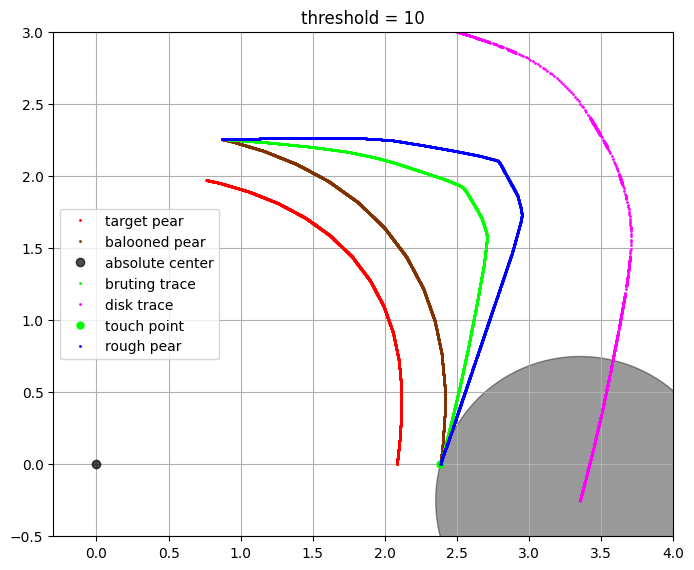

In [194]:
R = 1
n = 10000
i1, i2 = 1, 7
baloon_distance = 0.3
steps = 3
threshold = 10

rough   = GetContourFromOBJ("data\\B4969-B_PLANNING_pear\\rough.obj")
pear    = GetContourFromOBJ("data\\B4969-B_PLANNING_pear\\diamond.obj")

baloon_pear = LinearRing(LineString(pear).parallel_offset(baloon_distance, 'left', join_style=2))

rough_pts       = Contour2Points(rough, n)
pear_pts        = Contour2Points(pear, n)
baloon_pear_pts = Contour2Points(baloon_pear, n)

intersection_pts = rough.intersection(baloon_pear)

rotation_angle = GetAngleOfRotation(rough_pts, intersection_pts, i1, i2)
rotation_angle = matan(intersection_pts.geoms[i1])

pt_min = rotate(intersection_pts.geoms[i1], -rotation_angle, origin=Point(0.0,0.0), use_radians=True)
pt_max = rotate(intersection_pts.geoms[i2], -rotation_angle, origin=Point(0.0,0.0), use_radians=True)

rough_cut_rotated_pts       = RotateListOfPoints(PointsBetweenAngles(rough_pts, matan(intersection_pts.geoms[i1]), matan(intersection_pts.geoms[i2])), -rotation_angle)
pear_cut_rotated_pts        = RotateListOfPoints(PointsBetweenAngles(pear_pts, matan(intersection_pts.geoms[i1]), matan(intersection_pts.geoms[i2])), -rotation_angle)
baloon_pear_cut_rotated_pts = RotateListOfPoints(PointsBetweenAngles(baloon_pear_pts, matan(intersection_pts.geoms[i1]), matan(intersection_pts.geoms[i2])), -rotation_angle)

bruting_traces = []
disk_traces = []

bruting_traces.append(GetBrutingTrace(rough_cut_rotated_pts, baloon_pear_cut_rotated_pts, 1, steps, threshold))
disk_traces.append(GetParallelOffset(bruting_traces[-1], 1, R))

for j in range(2, steps+1):
    bruting_traces.append(GetBrutingTrace(bruting_traces[-1], baloon_pear_cut_rotated_pts, j, steps, threshold))
    disk_traces.append(GetParallelOffset(bruting_traces[-1], j, R))
    

# plot_points(rough_cut_rotated_pts, color=(0,0,1), markersize=1, label="rough pear")
plot_points(pear_cut_rotated_pts, color=(1,0,0), markersize=1, label="target pear")
plot_points(baloon_pear_cut_rotated_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

pear_cut_rotated = LineString(pear_cut_rotated_pts)
balooned_pear_cut_rotated = LineString(baloon_pear_cut_rotated_pts)
bruting_traces_plgs = []
for j in range(len(bruting_traces)):
    bruting_traces_plgs.append(LineString(bruting_traces[j]))

j = 0
k = 0
# k = len(rough_cut_rotated_pts)-1

plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

disk_pts = CreateDisk(R)
disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")
# plot_points(disk_traces[j][k], color=(1,0,1), markersize=5, label="center of disk")

current_rough_pts = rough_cut_rotated_pts if j == 0 else GetReversed(bruting_traces[j-1])
rough_trace = GetTrace(current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
plot_points(rough_trace, color=(0,0,1), markersize=1, label="rough pear")
# plot_points(rough_traces[2], color=(0,0,1), markersize=1, label="rough pear")

# for j in range(len(bruting_traces)):
#     plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
#     plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

# plot_polygon(Point(Polygon(rough_cut_rotated_pts).bounds[2]+R,0).buffer(R), add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

plt.rcParams["figure.figsize"] = (8.0, 8.0)
plt.xlim(-0.3, 4.0)
plt.ylim(-0.5, 3.0)
plt.title("threshold = " + str(threshold))
# plt.xlim(2.5, 2.8)
# plt.ylim(1.4, 1.7)
plt.legend()

In [ ]:
# R = 1
# n = 20000
# i1, i2 = 1, 7
# baloon_distance = 0.3
# steps = 3

# rough   = GetContourFromOBJ("data\\B4969-B_PLANNING_pear\\rough.obj")
# pear    = GetContourFromOBJ("data\\B4969-B_PLANNING_pear\\diamond.obj")

# baloon_pear = LinearRing(LineString(pear).parallel_offset(baloon_distance, 'left', join_style=2))

# rough_pts       = Contour2Points(rough, n)
# pear_pts        = Contour2Points(pear, n)
# baloon_pear_pts = Contour2Points(baloon_pear, n)

# intersection_pts = rough.intersection(baloon_pear)

# rotation_angle = GetAngleOfRotation(rough_pts, intersection_pts, i1, i2)
# rotation_angle = matan(intersection_pts.geoms[i1])

# pt_min = rotate(intersection_pts.geoms[i1], -rotation_angle, origin=Point(0.0,0.0), use_radians=True)
# pt_max = rotate(intersection_pts.geoms[i2], -rotation_angle, origin=Point(0.0,0.0), use_radians=True)

# rough_cut_rotated_pts       = RotateListOfPoints(PointsBetweenAngles(rough_pts, matan(intersection_pts.geoms[i1]), matan(intersection_pts.geoms[i2])), -rotation_angle)
# pear_cut_rotated_pts        = RotateListOfPoints(PointsBetweenAngles(pear_pts, matan(intersection_pts.geoms[i1]), matan(intersection_pts.geoms[i2])), -rotation_angle)
# baloon_pear_cut_rotated_pts = RotateListOfPoints(PointsBetweenAngles(baloon_pear_pts, matan(intersection_pts.geoms[i1]), matan(intersection_pts.geoms[i2])), -rotation_angle)

# bruting_traces = []
# disk_traces = []
# rough_traces = []

# rough_traces.append(rough_cut_rotated_pts)

# bruting_traces.append(GetBrutingTrace(rough_traces[-1], baloon_pear_cut_rotated_pts, 1, steps))
# disk_traces.append(GetParallelOffset(bruting_traces[-1], 1, R))

# disk = transform(lambda x, y, z=None: (x+disk_traces[-1][len(rough_cut_rotated_pts)-1].x, y+disk_traces[-1][len(rough_cut_rotated_pts)-1].y), Polygon(CreateDisk(R)))
# rough_traces.append(GetTrace(rough_traces[-1], bruting_traces[-1], disk_traces[-1], disk, R, 0, len(rough_cut_rotated_pts)-1))

# # for j in range(2, steps+1):
# #     bruting_traces.append(GetBrutingTrace(bruting_traces[-1], baloon_pear_cut_rotated_pts, j, steps))
# #     disk_traces.append(GetParallelOffset(bruting_traces[-1], j, R))

# #     disk = transform(lambda x, y, z=None: (x+disk_traces[-1][len(rough_cut_rotated_pts)-1].x, y+disk_traces[-1][len(rough_cut_rotated_pts)-1].y), Polygon(CreateDisk(R)))
# #     rough_traces.append(GetTrace(rough_traces[-1], bruting_traces[-1], disk_traces[-1], disk, R, j-1, len(rough_cut_rotated_pts)-1))


# bruting_traces.append(GetBrutingTrace(rough_traces[-1], baloon_pear_cut_rotated_pts, 2, steps))
# disk_traces.append(GetParallelOffset(bruting_traces[-1], 2, R))

# disk = transform(lambda x, y, z=None: (x+disk_traces[-1][len(rough_cut_rotated_pts)-1].x, y+disk_traces[-1][len(rough_cut_rotated_pts)-1].y), Polygon(CreateDisk(R)))
# rough_traces.append(GetTrace(rough_traces[-1], bruting_traces[-1], disk_traces[-1], disk, R, 1, len(rough_cut_rotated_pts)-1))
    

# # plot_points(rough_cut_rotated_pts, color=(0,0,1), markersize=1, label="rough pear")
# plot_points(pear_cut_rotated_pts, color=(1,0,0), markersize=1, label="target pear")
# plot_points(baloon_pear_cut_rotated_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
# plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

# pear_cut_rotated = LineString(pear_cut_rotated_pts)
# balooned_pear_cut_rotated = LineString(baloon_pear_cut_rotated_pts)
# bruting_traces_plgs = []
# for j in range(len(bruting_traces)):
#     bruting_traces_plgs.append(LineString(bruting_traces[j]))

# j = 1
# k = 0
# # k = len(rough_cut_rotated_pts)-1

# # plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
# plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

# disk_pts = CreateDisk(R)
# disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
# plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

# plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")
# # plot_points(disk_traces[j][k], color=(1,0,1), markersize=5, label="center of disk")

# current_rough_pts = rough_cut_rotated_pts if j == 0 else GetReversed(rough_traces[j])
# rough_trace = GetTrace(current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
# # plot_points(rough_trace, color=(0,0,1), markersize=1, label="rough pear")
# plot_points(rough_traces[2], color=(0,0,1), markersize=1, label="rough pear")

# # for j in range(len(bruting_traces)):
# #     plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
# #     plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

# # plot_polygon(Point(Polygon(rough_cut_rotated_pts).bounds[2]+R,0).buffer(R), add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

# plt.rcParams["figure.figsize"] = (8.0, 8.0)
# # plt.xlim(-0.3, 4.0)
# # plt.ylim(-0.5, 3.0)
# # plt.xlim(2.5, 2.8)
# # plt.ylim(1.4, 1.7)
# plt.legend()

In [ ]:
# l = 0
# for j in range(0, steps):
#     for k in tqdm(range(0, len(pear_cut_rotated_pts), 5)):
#         # plot_points(rough_cut_rotated_pts, color=(0,0,1), markersize=1, label="rough pear")
#         plot_points(pear_cut_rotated_pts, color=(1,0,0), markersize=1, label="target pear")
#         plot_points(baloon_pear_cut_rotated_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
#         plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

#         plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
#         plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

#         disk_pts = CreateDisk(R)
#         disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
#         plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

#         plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")
#         plot_points(disk_traces[j][k], color=(1,0,1), markersize=5, label="center of disk")

#         current_rough_pts = rough_cut_rotated_pts if j == 0 else GetReversed(bruting_traces[j-1])
#         rough_trace = GetTrace(current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
#         plot_points(rough_trace, color=(0,0,1), markersize=1, label="rough pear")

#         plt.rcParams["figure.figsize"] = (8.0, 8.0)
#         plt.xlim(-0.3, 4.0)
#         plt.ylim(-0.5, 3.0)
#         plt.legend()
#         plt.savefig("swing/test/big/" + str(j) + "/" + str(l) + ".png")
#         plt.close()
#         l += 1

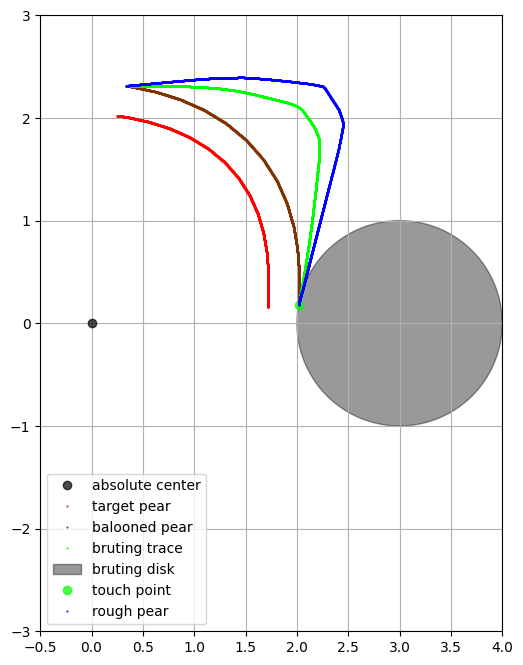

In [149]:
delta = 0.4
r = 2

j = 0
i = 0
k = 0
angle = matan(disk_traces[j][k])

xstep = (k/n)*delta*6
xval = R+r-affinity.rotate(disk_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True).x-xstep

plot_points(Point(0.0, 0.0), color=(0,0,0), alpha=0.7, label="absolute center")

plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(pear_cut_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(1,0,0), markersize=0.5, label="target pear")
plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(balooned_pear_cut_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(0.5,0.2,0), markersize=0.5, label="balooned pear")
plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces_plgs[j], -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(0,1,0), markersize=0.5, label="bruting trace")

disk_pts = CreateDisk(R)
disk = transform(lambda x, y, z=None: (x+R+r-xstep, y), Polygon(disk_pts))
plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(0,1,0), alpha=0.7, label="touch point")

current_rough_pts = rough_cut_rotated_pts if j == 0 else GetReversed(bruting_traces[j-1])

disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
rough_trace = GetTrace(current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
rotated_rough_trace = RotateListOfPoints(rough_trace, -angle)
transformed_rotated_rough_trace = TransformListOfPoints(rotated_rough_trace, xval, 0)
plot_points(transformed_rotated_rough_trace, color=(0,0,1), markersize=0.5, label="rough pear")

plt.rcParams["figure.figsize"] = (8.0,8.0)
plt.xlim(-0.5, 4)
plt.ylim(-3, 3)
plt.legend()

In [195]:
delta = 0.5
r = 2

path = "swing/test2/"

i = 0
for j in range(0, steps):
        for k in tqdm(range(0, len(pear_cut_rotated_pts), 30)):
                angle = matan(disk_traces[j][k])

                xstep = (k/n)*delta*6
                xval = R+r-affinity.rotate(disk_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True).x-xstep

                plot_points(Point(0.0, 0.0), color=(0,0,0), alpha=0.7, label="absolute center")

                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(pear_cut_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(1,0,0), markersize=0.5, label="target pear")
                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(balooned_pear_cut_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(0.5,0.2,0), markersize=0.5, label="balooned pear")
                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces_plgs[j], -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(0,1,0), markersize=0.5, label="bruting trace")

                disk_pts = CreateDisk(R)
                disk = transform(lambda x, y, z=None: (x+R+r-xstep, y), Polygon(disk_pts))
                plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(0,1,0), alpha=0.7, label="touch point")

                current_rough_pts = rough_cut_rotated_pts if j == 0 else GetReversed(bruting_traces[j-1])

                disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
                rough_trace = GetTrace(current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
                rotated_rough_trace = RotateListOfPoints(rough_trace, -angle)
                transformed_rotated_rough_trace = TransformListOfPoints(rotated_rough_trace, xval, 0)
                plot_points(transformed_rotated_rough_trace, color=(0,0,1), markersize=0.5, label="rough pear")

                plt.rcParams["figure.figsize"] = (8.0,8.0)
                plt.xlim(-0.5, 4)
                plt.ylim(-3, 3)
                plt.legend()
                plt.savefig(path+"general/" + str(i) + ".png")
                plt.close()
                i += 1

with imageio.get_writer(path+'movie.gif', mode='I', duration=0.01) as writer:
    for j in range(i):
        writer.append_data(imageio.imread("swing/test2/general/" + str(j) + ".png"))

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

C:\Users\konov\AppData\Local\Temp\ipykernel_9440\1570819649.py:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread("swing/test2/general/" + str(j) + ".png"))


In [213]:
ttime = []
dlttang = []
dltcent = []
rangles = []

for j in range(0, steps):
    for i in tqdm(range(len(rough_cut_rotated_pts)-2)):
        t1 = i/len(rough_cut_rotated_pts)
        t2 = (i+1)/len(rough_cut_rotated_pts)
        pttang1 = bruting_traces[j][i]
        ptcent1 = disk_traces[j][i]
        pttang2 = bruting_traces[j][i+1]
        ptcent2 = disk_traces[j][i+1]
        dsttang = sqrt((pttang2.x-pttang1.x)**2+(pttang2.y-pttang1.y)**2)
        dstcent = sqrt((ptcent2.x-ptcent1.x)**2+(ptcent2.y-ptcent1.y)**2)
        angle = atan2(ptcent1.y, ptcent1.x)
        dlttang.append(dsttang/(t2-t1))
        dltcent.append(dstcent/(t2-t1))
        ttime.append(t1+j)
        rangles.append(angle)

  0%|          | 0/1911 [00:00<?, ?it/s]

  0%|          | 0/1911 [00:00<?, ?it/s]

  0%|          | 0/1911 [00:00<?, ?it/s]

In [210]:
whole_area = Polygon(rough_cut_rotated_pts).area
disk_pts = CreateDisk(R)
area = []

for j in range(0, steps):
    for i in tqdm(range(len(rough_cut_rotated_pts)-2)):

        disk = transform(lambda x, y, z=None: (x+disk_traces[j][i].x, y+disk_traces[j][i].y), Polygon(disk_pts))
        current_rough_pts = rough_cut_rotated_pts if j == 0 else GetReversed(bruting_traces[j-1])
        rough_trace = GetTrace(current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, i)
        cur_area = Polygon(rough_trace).area

        area.append(whole_area-cur_area)

  0%|          | 0/1911 [00:00<?, ?it/s]

  0%|          | 0/1911 [00:00<?, ?it/s]

  0%|          | 0/1911 [00:00<?, ?it/s]

In [223]:
darea = []

for j in range(0, steps):
    for i in tqdm(range(len(rough_cut_rotated_pts)-3)):
        t1 = i/len(rough_cut_rotated_pts)
        t2 = (i+1)/len(rough_cut_rotated_pts)
        area1 = area[i+j*(len(rough_cut_rotated_pts)-2)]
        area2 = area[i+1+j*(len(rough_cut_rotated_pts)-2)]
        darea.append((area2-area1)/(t2-t1))

  0%|          | 0/1910 [00:00<?, ?it/s]

  0%|          | 0/1910 [00:00<?, ?it/s]

  0%|          | 0/1910 [00:00<?, ?it/s]

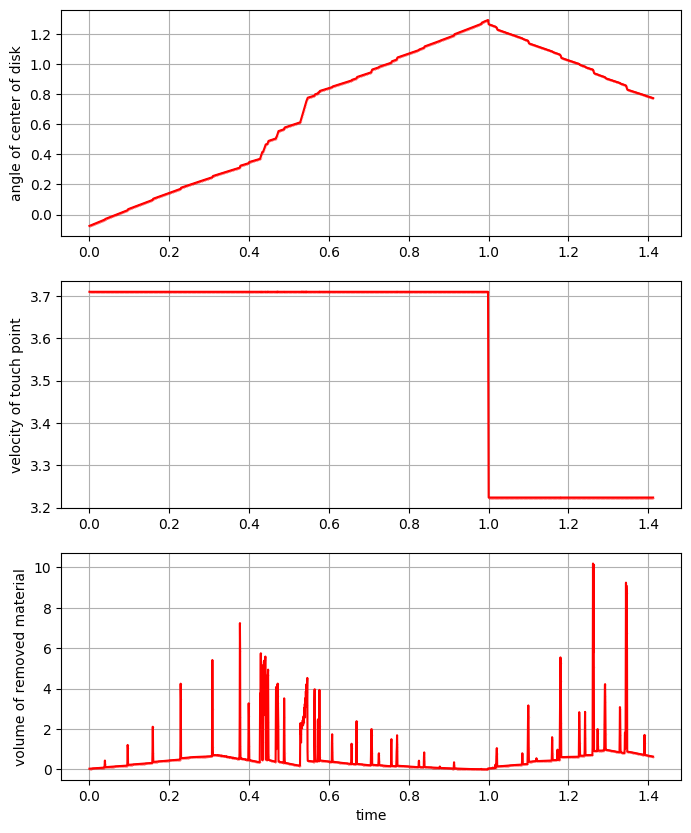

In [224]:
fig, axs = plt.subplots(3, 1)
fig.set_size_inches(8.0, 10.0)

k = 2700

axs[0].plot(ttime[:k], rangles[:k], marker='.', color="red", markersize=0.1)
axs[0].set_ylabel('angle of center of disk')
axs[0].grid(True)

axs[1].plot(ttime[:k], dlttang[:k], marker='.', linestyle="-", color="red", markersize=0.1)
axs[1].set_ylabel('velocity of touch point')
axs[1].grid(True)

axs[2].plot(ttime[:k], darea[:k], marker='.', linestyle="-", color="red", markersize=0.1)
axs[2].set_xlabel('time')
axs[2].set_ylabel('volume of removed material')
axs[2].grid(True)

In [225]:
path = 'swing/test2/'

i = 0
for j in range(0, steps):
    for k in tqdm(range(0, len(pear_cut_rotated_pts), 30)):
        fig, axs = plt.subplots(3, 1)
        fig.set_size_inches(10.0, 9.0)

        axs[0].plot(ttime[:(k+len(pear_cut_rotated_pts)*j)], rangles[:(k+len(pear_cut_rotated_pts)*j)], marker='.', color="red", markersize=0.1)
        axs[0].set_ylabel('angle of center of disk')
        axs[0].grid(True)

        axs[1].plot(ttime[:(k+len(pear_cut_rotated_pts)*j)], dlttang[:(k+len(pear_cut_rotated_pts)*j)], marker='.', linestyle="-", color="red", markersize=0.1)
        axs[1].set_ylabel('velocity of touch point')
        axs[1].grid(True)

        axs[2].plot(ttime[:(k+len(pear_cut_rotated_pts)*j)], darea[:(k+len(pear_cut_rotated_pts)*j)], marker='.', linestyle="-", color="red", markersize=0.1)
        axs[2].set_xlabel('time')
        axs[2].set_ylabel('volume of removed material')
        axs[2].grid(True)

        fig.savefig('swing/test2/graph/' + str(i) + '.png')   # save the figure to file
        plt.close(fig)
        i += 1

with imageio.get_writer(path+'movie_graph.gif', mode='I', duration=0.01) as writer:
    for j in range(i):
        writer.append_data(imageio.imread('swing/test2/graph/' + str(j) + ".png"))

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

C:\Users\konov\AppData\Local\Temp\ipykernel_9440\4256481538.py:28: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread('swing/test2/graph/' + str(j) + ".png"))
